# 01_summary_statistics.ipynb

In [8]:
import sys
sys.path.append('..')
import contextily as cx
import figure_utilities
import figure_and_table_constants
from analysis_utilities import produce_summary_statistics
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
import numpy as np
import os
import pandas as pd

# Store paths.
INPUT_DATA_UNRESTRICTED = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/data/03_cleaned/unrestricted.csv"
INPUT_DATA_RESTRICTED = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/data/03_cleaned/zestimates_analysis.csv"
OUTPUT_TABLES = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/output/summary_statistics/tables"
OUTPUT_FIGURES = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/output/summary_statistics/figures"

# Read unrestricted dataset into memory.
unrestricted_df = pd.read_csv(INPUT_DATA_UNRESTRICTED)

# Drop malformed addresses.
unrestricted_df = unrestricted_df.loc[~unrestricted_df['property_address_full'].str.contains("span, span span"), :]

# So we can use 'case_number' like a column
unrestricted_df = unrestricted_df.reset_index()

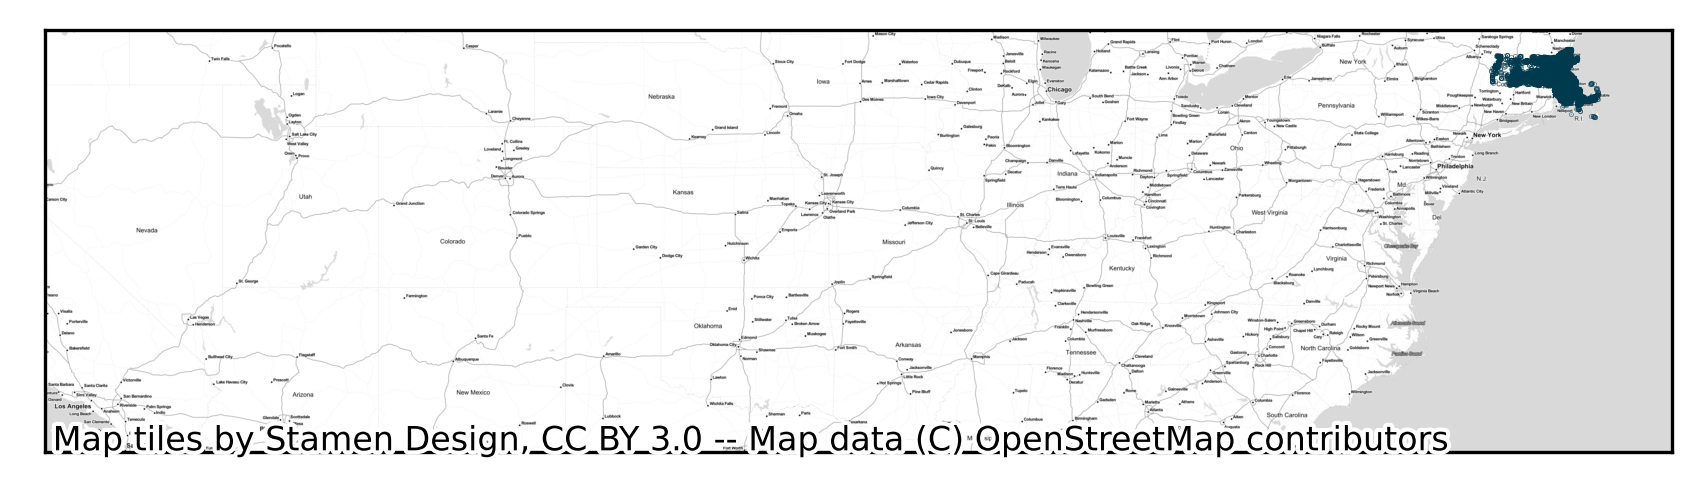

In [9]:
# Plot evictions spatially.
unrestricted_gdf = gpd.GeoDataFrame(unrestricted_df,
                                    geometry=gpd.points_from_xy(unrestricted_df['longitude'],
                                                                unrestricted_df['latitude']))
unrestricted_gdf = unrestricted_gdf.set_crs("EPSG:4326")
unrestricted_gdf = unrestricted_gdf.to_crs("EPSG:3857")
fig, ax = plt.subplots(figsize=(7, 9))
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_xticks([])
unrestricted_gdf.plot(ax=ax,
                      color=figure_and_table_constants.Colors.P3,
                      markersize=0.05,
                      alpha=0.5)
cx.add_basemap(ax=ax, crs="EPSG:3857", source=cx.providers.Stamen.TonerLite)
plt.show()
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "evictions_map.png"))

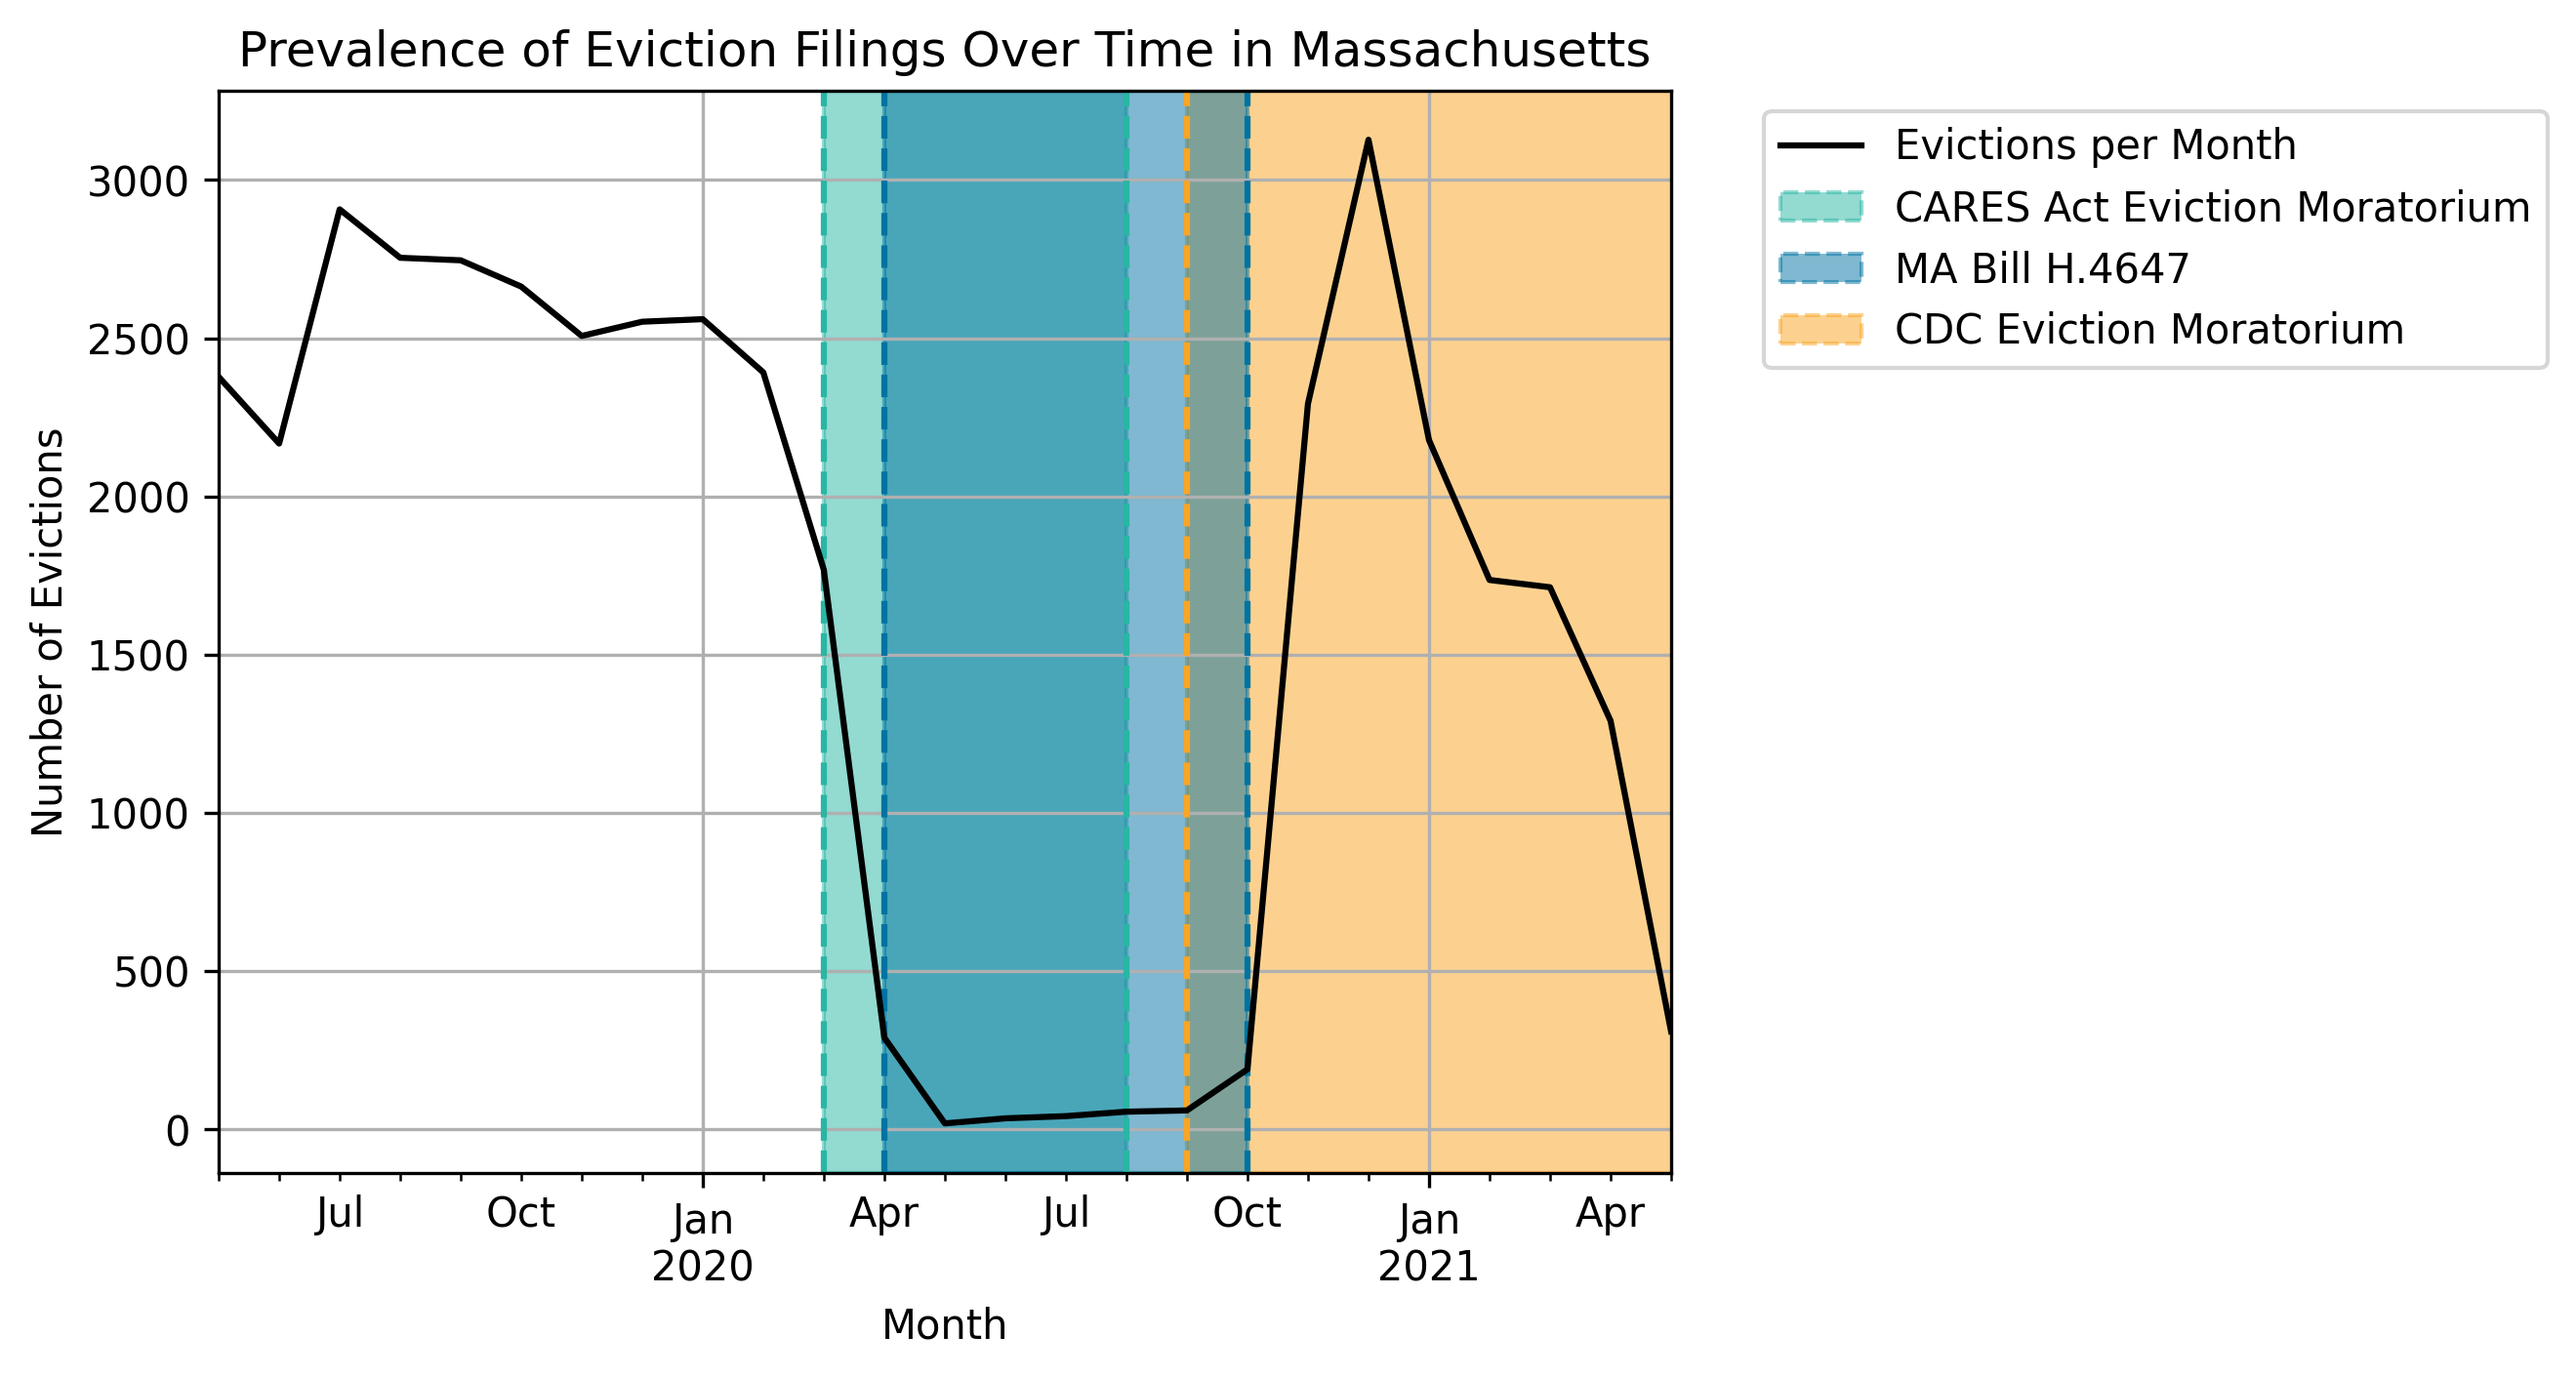

In [10]:
# Plot the number of eviction filings over time.
unrestricted_df.loc[:, 'last_day_of_file_month'] = (pd.to_datetime(unrestricted_df['file_date']) +
                                                    pd.tseries.offsets.MonthEnd(0))
filings_per_month = unrestricted_df.groupby('last_day_of_file_month')['case_number'].count()

# Plot eviction filing counts.
fig, ax = plt.subplots()
filings_per_month.plot(ax=ax, kind='line', color=figure_and_table_constants.Colors.SUMMARY_STATISTICS_COLOR,
                       zorder=100)
ax.set_title("Prevalence of Eviction Filings Over Time in Massachusetts")
ax.set_ylabel("Number of Evictions")
ax.set_xlabel("Month")
ax.grid(True)

# Plot the beginning and end of the CARES act moratorium.
CARES_beginning = pd.Timestamp("2020-03-27")
CARES_end = pd.Timestamp("2020-08-23")
CARES_color = figure_and_table_constants.Colors.P1
figure_utilities.plot_labeled_vline(ax=ax, x=CARES_beginning, text='', color=CARES_color)
figure_utilities.plot_labeled_vline(ax=ax, x=CARES_end, text='', color=CARES_color)
ax.axvspan(CARES_beginning, CARES_end, color=CARES_color, alpha=0.5)

# Plot the beginning and end of the CDC moratorium.
CDC_beginning = pd.Timestamp("2020-09-04")
CDC_end = pd.Timestamp("2021-08-26")
CDC_color = figure_and_table_constants.Colors.P2
figure_utilities.plot_labeled_vline(ax=ax, x=CDC_beginning, text='', color=CDC_color)
figure_utilities.plot_labeled_vline(ax=ax, x=CDC_end, text='', color=CDC_color)
ax.axvspan(CDC_beginning, CDC_end, color=CDC_color, alpha=0.5)

# Plot the beginning and end of the MA state moratorium.
MA_beginning = pd.Timestamp("2020-04-20")
MA_end = pd.Timestamp("2020-10-17")
MA_color = figure_and_table_constants.Colors.P7
figure_utilities.plot_labeled_vline(ax=ax, x=MA_beginning, text='', color=MA_color)
figure_utilities.plot_labeled_vline(ax=ax, x=MA_end, text='', color=MA_color)
ax.axvspan(MA_beginning, MA_end, color=MA_color, alpha=0.5)

# Build legend.
legend_elements = [Line2D([0], [0], color='black', label='Evictions per Month'),
                   Patch(facecolor=CARES_color, edgecolor=CARES_color, label='CARES Act Eviction Moratorium',
                         alpha=0.5, linestyle='--'),
                   Patch(facecolor=MA_color, edgecolor=MA_color, label='MA Bill H.4647', alpha=0.5,
                         linestyle='--'),
                   Patch(facecolor=CDC_color, edgecolor=CDC_color, label='CDC Eviction Moratorium', alpha=0.5,
                         linestyle='--')]
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "filings_over_time.png"))

In [11]:
# Produce summary statistics for unrestricted sample.
treatment_date_variable = 'file_date'
summary_statistics_unrestricted, variable_display_names_dict  = produce_summary_statistics(unrestricted_df,
                                                                                           treatment_date_variable=treatment_date_variable)

# Rename rows.
variable_names = summary_statistics_unrestricted.index.get_level_values(1)
summary_statistics_unrestricted = summary_statistics_unrestricted.rename(index=variable_display_names_dict)

# Rename columns.
summary_statistics_unrestricted.index = summary_statistics_unrestricted.index.set_names(["Panel", "Variable"])
column_display_names_dict = {'mean': "Mean", 'std': "S.D.", 'count': "N", '50%': 'Median'}
summary_statistics_unrestricted = summary_statistics_unrestricted.rename(columns=column_display_names_dict)
summary_statistics_unrestricted = summary_statistics_unrestricted.sort_values(['Panel', 'Variable'])

# Export to LaTeX.
filename = os.path.join(OUTPUT_TABLES, "summary_statistics.tex")
latex = (summary_statistics_unrestricted
         .style
         .format(formatter={
                            'Mean': "{:,.2f}",
                            'Median': "{:,.2f}",
                            'S.D.': "{:,.2f}",
                            'N': "{:,.0f}"})
         .format_index("\\textit{{{}}}", escape="latex", axis=0, level=0)
         .to_latex(None,
                   column_format="llcccc",
                   hrules=True,
                   clines="skip-last;data")).replace("{*}", "{4cm}")
with open(filename, 'w') as file:
    file.write(latex)
summary_statistics_unrestricted

Mean  \
Panel                                            Variable                                                           
Panel A: Pre-treatment Zestimates                Change in Crimes Reported, Jan. 2017 to Jan. 2019      -0.007021   
                                                 Change in Zestimate, Jan. 2017 to Jan. 2019         46593.084218   
                                                 Crimes reported, Jan. 2017                              0.209849   
                                                 Zestimate, Jan. 2017                               298898.218781   
Panel B: Census Tract Characteristics            Jobs per square mile (2010)                          4802.708856   
                                                 Median household income (2016)                      52695.023912   
                                                 Median two bedroom rent (2015)                       1116.731552   
                                                 Population density (2010)                            9151.916193   
                                                 Share below poverty line                                0.200949   
                                                 Share white (2010)                                      0.583328   
                                                 Share with bachelor's degree                            0.262134   
                                                 Share with commute $<$15 minutes (2010)                 0.280903   
Panel C: Case Initiation                         For cause                                               0.122134   
                                                 No cause                                                0.107478   
                                                 Non-payment of rent                                     0.749251   
Panel D: Defendant and Plaintiff Characteristics Defendant has an attorney                               0.086439   
                                                 Defendant is an entity                                  0.006260   
                                                 Plaintiff has an attorney                               0.839962   
                                                 Plaintiff is an entity                                  0.703319   
Panel E: Case Resolution                         Case defaulted                                          0.195586   
                                                 Case dismised                                           0.286247   
                                                 Case duration                                          57.808385   
                                                 Case heard                                              0.057421   
                                                 Case mediated                                           0.414469   
                                                 Money judgment                                       1890.016902   
Panel F: Post-treatment Zestimates               Crimes one year after filing date                       0.187362   
                                                 Crimes two years after filing date                      0.180613   
                                                 Zestimate one year after filing date               421590.212067   
                                                 Zestimate two years after filing date              477931.835124   

                                                                                                           Median  \
Panel                                            Variable                                                           
Panel A: Pre-treatment Zestimates                Change in Crimes Reported, Jan. 2017 to Jan. 2019       0.000000   
                                                 Change in Zestimate, Jan. 2017 to Jan. 2019         37330.000000   
             

In [12]:
# Load restricted data.
restricted_df = pd.read_csv(INPUT_DATA_RESTRICTED)
# Store treatment date variable -- may be either file_date or latest_docket_date -- and drop rows where missing.
treatment_date_variable = 'file_date'
treatment_year_variable = treatment_date_variable.replace("date", "year")
treatment_month_variable = treatment_date_variable.replace("date", "month")
restricted_df = restricted_df.dropna(subset=['file_date'])
print(f"Limiting sample to {len(restricted_df)} evictions for which we observe the filing date and the latest docket date.")

# Create dictionaries to map between string representation and integer representation of each month.
years = [str(year) for year in range(2013, 2023)]
months = ["0" + str(month) for month in range(1, 10)] + [str(month) for month in range(10, 13)]
value_vars = ["2012-12"] + [str(year) + "-" + str(month) for year in years for month in months]
month_to_int_dictionary = {key: value for value, key in enumerate(value_vars)}
int_to_month_dictionary = {key: value for key, value in enumerate(value_vars)}

Limiting sample to 3298 evictions for which we observe the filing date and the latest docket date.


In [13]:
treatment_timings = (restricted_df
                     .groupby([treatment_month_variable, 'judgment_for_plaintiff'])['case_number']
                     .count()
                     .reset_index()
                     .fillna(0))
treatment_timings = treatment_timings.pivot(index=treatment_month_variable, columns='judgment_for_plaintiff').fillna(0)
treatment_timings.columns = ["Cases Won By Defendant", "Cases Won By Plaintiff"]
portion_of_all_cases = (treatment_timings['Cases Won By Plaintiff'] + treatment_timings['Cases Won By Defendant']) / len(restricted_df)
treatment_timings = pd.concat([treatment_timings, portion_of_all_cases.rename('Portion of All Cases')], axis=1)
sum_across_filing_date = pd.DataFrame(treatment_timings.sum(axis=0)).T
sum_across_filing_date.index = ["All Filing Months"]
treatment_timings = pd.concat([sum_across_filing_date, treatment_timings], axis=0)
treatment_timings.index = treatment_timings.index.rename("Filing Month")

# Export to LaTeX.
filename = os.path.join(OUTPUT_TABLES, "treatment_timings.tex")
treatment_timings.style.format(formatter={'Cases Won By Plaintiff': '{:,.0f}',
                                          'Cases Won By Defendant': '{:,.0f}',
                                          'Portion of All Cases': '{:0.2f}'}).to_latex(filename, column_format="lccc", hrules=True)
treatment_timings

,Cases Won By Defendant,Cases Won By Plaintiff,Portion of All Cases
Filing Month,,,
All Filing Months,859.0,2439.0,1.000000
2019-05,101.0,156.0,0.077926
2019-06,38.0,151.0,0.057307
2019-07,42.0,198.0,0.072771
2019-08,31.0,177.0,0.063069
2019-09,37.0,156.0,0.058520
2019-10,33.0,148.0,0.054882
2019-11,23.0,138.0,0.048817
2019-12,28.0,171.0,0.060340


In [14]:
# Reshape from wide to long.
restricted_df = pd.melt(restricted_df,
                        id_vars=['case_number', treatment_month_variable, 'judgment_for_plaintiff'],
                        value_vars=value_vars, var_name='month', value_name='zestimate')
restricted_df = restricted_df.sort_values(by=['case_number', 'month'])

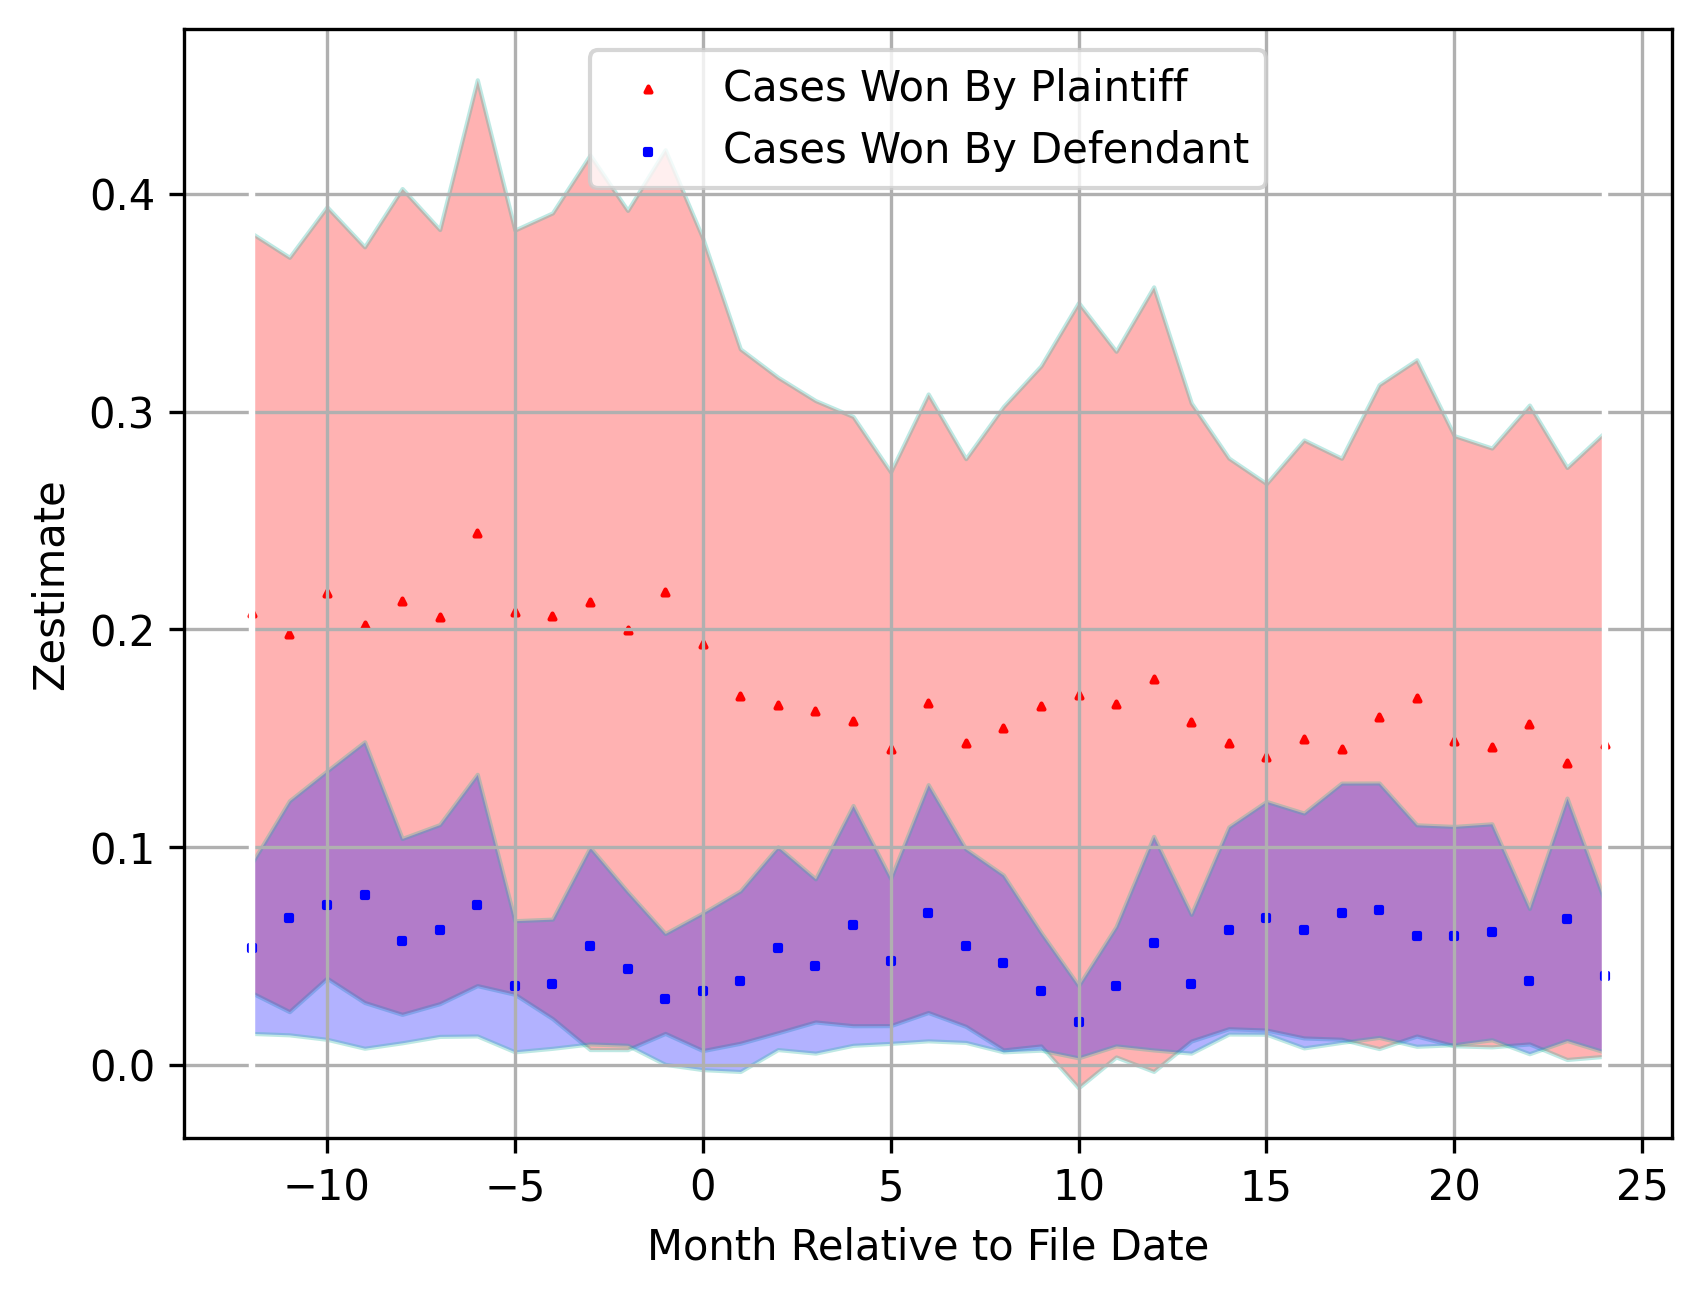

In [15]:
# Plot path of the outcome in the treated vs. control group.

# Convert months from string format to integer format.
restricted_df.loc[:, 'month'] = restricted_df['month'].replace(month_to_int_dictionary)
restricted_df.loc[:, treatment_month_variable] = restricted_df[treatment_month_variable].replace(month_to_int_dictionary)

# Generate month relative to treatment.
restricted_df.loc[:, 'month_relative_to_treatment'] = ((restricted_df['month'] - restricted_df[treatment_month_variable])
                                                       .astype(int))



# Aggregate by treatment-relative month and treatment status.
start_month_relative_to_treatment = -12
end_month_relative_to_treatment = 24
restricted_df = (restricted_df.groupby(['month_relative_to_treatment', 'judgment_for_plaintiff'])['zestimate']
                 .agg([np.mean, np.std, 'count'])
                 )
restricted_df.loc[:, 'se'] = restricted_df['std'] / np.sqrt(restricted_df['count'])
restricted_df.loc[:, 'y_upper'] = restricted_df['mean'] + 1.96 * restricted_df['se']
restricted_df.loc[:, 'y_lower'] = restricted_df['mean'] - 1.96 * restricted_df['se']

# Separate into control and treatment group
treated_units = restricted_df.loc[(slice(start_month_relative_to_treatment, end_month_relative_to_treatment), 1), :].reset_index()
control_units = restricted_df.loc[(slice(start_month_relative_to_treatment, end_month_relative_to_treatment), 0), :].reset_index()

# Plot event study-style plot of trends in Zestimates.
fig, ax = plt.subplots()
if treatment_date_variable == 'file_date':
    ax.set_xlabel("Month Relative to File Date")
elif treatment_date_variable == 'latest_docket_date':
    ax.set_xlabel("Month Relative to Latest Docket Date")
else:
    raise ValueError("Invalid treatment_date_variable.")
ax.set_ylabel("Zestimate")
for dataset, color, marker, label in zip([treated_units, control_units],
                                         ['red', 'blue'],
                                         ["^", "s"],
                                         ["Cases Won By Plaintiff",
                                          "Cases Won By Defendant"]):
    x = dataset['month_relative_to_treatment'].values
    y = dataset['mean'].values
    y_upper = dataset['y_upper'].values
    y_lower = dataset['y_lower'].values
    figure_utilities.plot_scatter_with_shaded_errors(ax=ax,
                                                     x=x,
                                                     y=y,
                                                     y_upper=y_upper,
                                                     y_lower=y_lower,
                                                     label=label,
                                                     point_color=color,
                                                     marker=marker,
                                                     error_color=color,
                                                     error_opacity=0.3)

ax.legend()
ax.grid(True)
plt.show()
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "trends_in_zestimates.png"))


